In [ ]:
from openai import OpenAI
from openai.types.chat import ChatCompletionMessageParam
from tqdm import tqdm
from typing import Dict, Iterable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scoring_functions as fn
import hashlib
import os
import json
import dill
import base64
import utils as u
import prompty

# suppress bert warnings
from transformers import logging
logging.set_verbosity_error()

In [3]:
# Init variables

scenario = ""
split_response = False
prompt_file = ""
tasks = []
metric_scorers = []

In [4]:
# Foundry Local
client = OpenAI(
    api_key="local",
    base_url="http://localhost:5272/v1"
)
models = ["qwen2.5-0.5b-instruct-generic-gpu", "qwen2.5-1.5b-instruct-generic-gpu", "qwen2.5-7b-instruct-generic-gpu", "Phi-4-mini-instruct-generic-gpu", "Phi-3.5-mini-instruct-generic-gpu", "mistralai-Mistral-7B-Instruct-v0-2-generic-gpu"]
# Ollama
# client = OpenAI(
#     api_key="local",
#     base_url="http://localhost:11434/v1"
# )
# models = ["phi3.5", "phi4-mini", "gemma3:4b", "falcon3:3b", "falcon3:7b", "qwen2.5:3b", "llama3.2"]
num_runs = 20
cache_results = True
cache_scores = True
# See below for explanation
normalize_bert = True

Here are some metrics that can be used to evaluate the quality of text generation models. Based on an example of a generated string `getUser` and a reference string `getUserById`.

Metric|Focus|Evaluates|Example Use Cases
------|-----|---------|-----------------
ROUGE-1|Overlap of individual tokens (`get`, `User`, `By`, `Id`)|Basic content overlap|Extractive summarization, keyword matching
ROUGE-2|Overlap of bigrams (word pairs, `getUser`, `UserBy`, etc.)|Phrase-level coherence|Abstractive summarization, contextual accuracy
ROUGE-L|Longest Common Subsequence capturing order-sensitive matches (`getUser` is a subsequence of `getUserById`).|Sequence-level similarity|Document-level summarization, fluency
BLEU|Precision of n-gram overlap|Precision-based fluency and content. Captures short-term relationships, such as matching substrings (`getUser` and `getUserById` share significant overlap). Does not prioritize recall (e.g., missing `ById` might not be heavily penalized).|Machine translation, paraphrase detection.
Normalized edit distance (Levenshtein distance)|Minimum number of single-character edits to transform one string into another|Character-level similarity. Intuitively captures similarity, including minor deviations (e.g., `getUser` is close to `getUserById` with just 5 characters missing). Does not capture semantic similarity or n-gram overlaps, treating all mismatches equally.|Spelling correction, OCR, speech recognition
BERTScore|Cosine similarity of contextual embeddings|Semantic similarity|Text generation, paraphrase detection

#### **General Thresholds for BERTScore Precision**
| **BERTScore Precision** | **Interpretation** | **Likelihood of Hallucination (Extra Words)** |
|------------------|-------------------------------|--------------------------------|
| **0.95 – 1.00** | **Excellent match** ✅ | Very low chance of hallucination |
| **0.90 – 0.94** | **Strong match** 👍 | Minimal extra words |
| **0.85 – 0.89** | **Moderate match** ⚠️ | Possible additional content |
| **0.80 – 0.84** | **Weak match** ❌ | Significant extra words present |
| **< 0.80**      | **Poor match** ❌❌ | High chance of hallucination |

If you want **BERTScore Precision** to contribute strongly to the **overall score** and **penalize values below 0.85**, you need to **transform and normalize** it into a more responsive scale.

- **BERTScore Precision ranges from [0,1]**, but small drops (e.g., from 0.95 to 0.85) should **significantly reduce the overall score**.
- Values **above 0.90** should have a strong positive contribution.
- Values **below 0.85** should sharply reduce the score.

##### Piecewise Linear Normalization (Harsh Penalty Below 0.85)
A simple way to scale it is:

\begin{align}
\text{Scaled BERTScore} =
\begin{cases} 
1, & P \geq 0.95 \\
\frac{P - 0.75}{0.20}, & 0.75 \leq P < 0.95 \\
0, & P < 0.75
\end{cases}
\end{align}


- **Above 0.95** → Gets full contribution (1).
- **Between 0.75 – 0.95** → Linearly scaled so that **0.85 is penalized heavily**.
- **Below 0.75** → Drops to **zero contribution** (hard penalty).

In [5]:
# Select scenario

# %run ./tests/test_DevProxy_v0_29_api_service_name.ipynb
# %run ./tests/test_DevProxy_v0_29_operation_description.ipynb
%run ./tests/test_DevProxy_v0_29_operation_id.ipynb
# %run ./tests/test_DevProxy_v0_29_singular_noun.ipynb

In [6]:
# Prepare data before processing

if split_response:
    for task in tasks:
        task['reference_texts'] = [fn.split_camel_case(text) for text in task['reference_texts']]

In [7]:
# Cache functions

def hash_string(input_string: str) -> str:
    """
    Generate a SHA-256 hash for the given input string.
    """
    sha256_hash = hashlib.sha256()
    sha256_hash.update(input_string.encode('utf-8'))
    return sha256_hash.hexdigest()

def get_cache_key_for_task(model_name: str, messages: Iterable[ChatCompletionMessageParam], temp: float=None, top_p: float=None) -> str:
    """
    Generate a cache key for the given model, messages, temperature and top_p.
    """
    # Convert messages to a string representation
    prompt = ""
    for message in messages:
        prompt += f"{message['role']}: {message['content']}\n"
    return f"t_{hash_string(f"{model_name}_{prompt}_{temp}_{top_p}")}"

def get_cache_key_for_score(reference_texts: list[str], generated: str, metric_scorers: list) -> str:
    """
    Generate a cache key for the given reference texts, generated text and metric scorers.
    """
    scorers_hash = base64.b64encode(dill.dumps(metric_scorers)).decode('utf-8')
    reference_texts_hash = base64.b64encode(dill.dumps(reference_texts)).decode('utf-8')
    return f"s_{hash_string(f"{reference_texts_hash}_{generated}_{scorers_hash}")}"

def get_from_cache(cache_key: str) -> list:
    """
    Get responses from cache.
    """
    cache_file_path = f".cache/{cache_key}.json"
    if os.path.exists(cache_file_path):
        with open(cache_file_path, 'r') as cache_file:
            return json.load(cache_file)
    return []

def save_to_cache(cache_key: str, data):
    """
    Save responses to cache.
    """
    cache_file_path = f".cache/{cache_key}.json"
    os.makedirs(os.path.dirname(cache_file_path), exist_ok=True)
    with open(cache_file_path, 'w') as cache_file:
        json.dump(data, cache_file)

In [8]:
# Load responses from models

def get_model_response(model_name: str, messages: Iterable[ChatCompletionMessageParam], temp: float=None, top_p: float=None) -> str:
    """
    Get response from a specific model using Ollama.
    """
    try:
        completion = client.chat.completions.create(
            model=model_name,
            messages=messages,
            temperature=temp,
            top_p=top_p,
        )
        return completion.choices[0].message.content
    except Exception as e:
        print(f"Error: {e}")
        return ""
    
def load_responses():
    """
    Load responses from models.
    """
    responses = []
    prompt = u.load_prompty(prompt_file)
    global scenario
    scenario = prompt.name
    total = len(models) * len(tasks) * num_runs
    with tqdm(total=total) as pbar:
        for model_name in models:
            for task in tasks:
                cached_responses = []
                messages = prompty.prepare(prompt, task['inputs'])
                cache_key = get_cache_key_for_task(model_name, messages, prompt.model.configuration.get('temperature'), prompt.model.configuration.get('top_p'))

                if cache_results:
                    cached_responses = get_from_cache(cache_key)
                    if cached_responses:
                        pbar.update(len(cached_responses))
                        responses.extend(cached_responses)
                        continue

                for i in range(num_runs):
                    pbar.set_description(f"Response: {model_name}, {task['name']} ({i+1}/{num_runs})")
                    pbar.update(1)
                    # print(f"Getting response {i+1}/{num_runs} from {model_name}...", end="")
                    response = get_model_response(model_name, messages, prompt.model.configuration.get('temperature'), prompt.model.configuration.get('top_p'))
                    # print(f"{response['total_duration'] / 1_000_000_000}s.")
                    res = {
                        'model': model_name,
                        'name': task['name'],
                        'reference_texts': task['reference_texts'],
                        'response': response
                    }
                    responses.append(res)
                    if cache_results:
                        cached_responses.append(res)

                if cache_results:
                    save_to_cache(cache_key, cached_responses)
    return responses

responses = load_responses()

100%|██████████| 480/480 [00:00<00:00, 4198.48it/s]


In [9]:
# Score responses

def compute_combined_score(reference_texts: list[str], generated: str, metric_scorers: list) -> Dict[str, float]:
    combined_score = {'score': 0}
    for scorer in metric_scorers:
        score = scorer['fn'](reference_texts, generated)
        weighted_score_scorer = scorer['weight'] * score
        combined_score[scorer['name']] = weighted_score_scorer
        combined_score['score'] += weighted_score_scorer

    return combined_score

with tqdm(total=len(responses)) as pbar:
    for response in responses:
        cache_key = get_cache_key_for_score(response['reference_texts'], response['response'], metric_scorers)

        pbar.set_description(f"Scoring: {response['model']}, {response['name']}")
        pbar.update(1)

        if split_response:
            # prepend space before each uppercase letter needed to properly calculate
            # similarity
            response['response'] = fn.split_camel_case(response['response'])
        
        score = None
        if cache_scores:
            score = get_from_cache(cache_key)

        if not score:
            score = compute_combined_score(response['reference_texts'], response['response'], metric_scorers)
            if cache_scores:
                save_to_cache(cache_key, score)

        # print(f"Scoring {response['model']} response: {response['response']}...")
        for scorer in metric_scorers:
            response[scorer['name']] = score[scorer['name']]
        response['combined_score'] = score['score']

Scoring: mistralai-Mistral-7B-Instruct-v0-2-generic-gpu, postCalendarForUser: 100%|██████████| 480/480 [00:00<00:00, 1176.76it/s]


In [10]:
# Data frame for score per response

columns = ['model', 'name', 'response']
for scorer in metric_scorers:
    columns.append(scorer['name'])
columns.append('combined_score')
df_response_scores = pd.DataFrame(responses, columns=columns)

In [11]:
# Data frame for average score per model and task

# prevent wrapping of text
pd.set_option("display.width", 80)
pd.set_option("display.max_colwidth", 80)

# calculate average combined score per task per model
df_score_model_task = pd.DataFrame(responses)
df_score_model_task = df_score_model_task.groupby(['name', 'model']).agg({'combined_score': 'mean'}).reset_index()
df_score_model_task = df_score_model_task.sort_values(['name', 'combined_score'], ascending=[True, False])
df_score_model_task = df_score_model_task.rename(columns={'combined_score': 'average_combined_score'})

# calculate average combined score per model
# sort descending by the average combined score
# rename combined_score to average_combined_score
df_score_model = pd.DataFrame(responses)
df_score_model = df_score_model.groupby('model').agg({'combined_score': 'mean'}).reset_index()
df_score_model = df_score_model.sort_values('combined_score', ascending=False)
df_score_model = df_score_model.rename(columns={'combined_score': 'average_combined_score'})

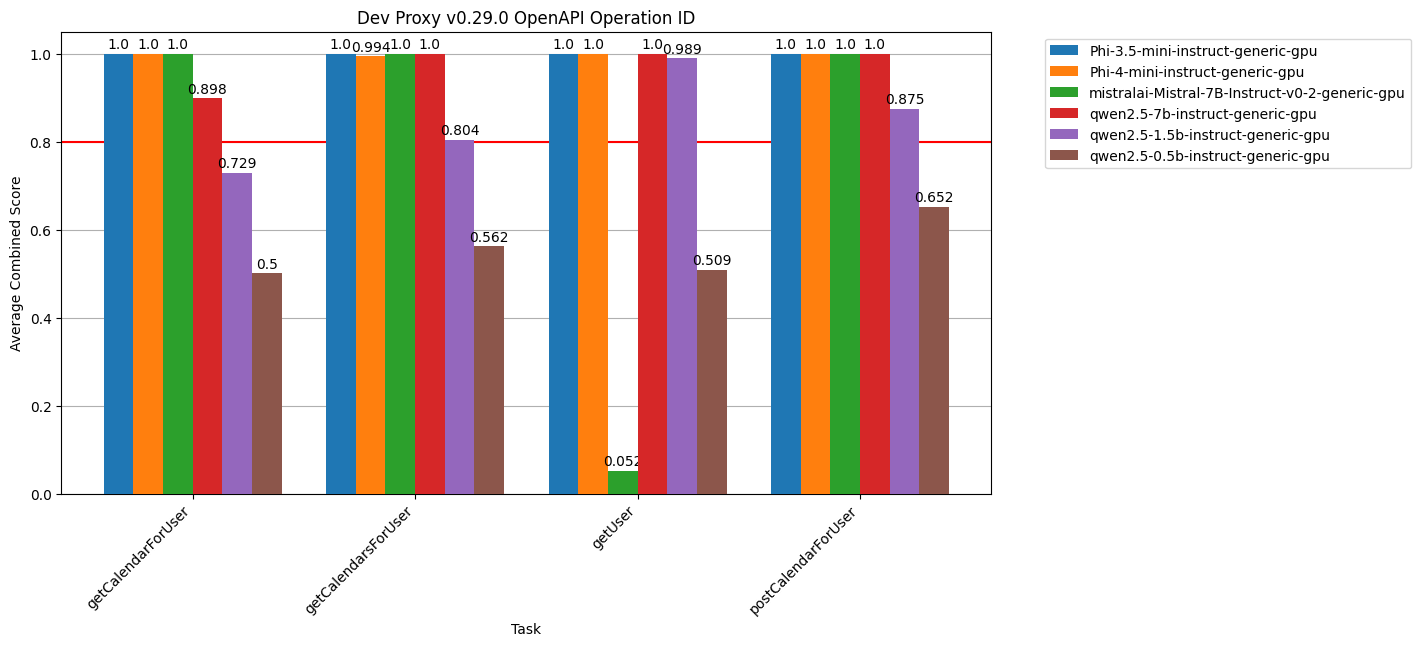

In [12]:
# Chart for score per model per task

# Get unique reference texts and models
task_names = df_score_model_task['name'].unique()
models = df_score_model_task['model'].unique()

# Set the positions and width for the bars
x = np.arange(len(task_names))
width = 0.8 * (len(task_names) / (len(task_names) * len(models)))

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Add grid lines behind the bars
ax.grid(True, axis='y', zorder=0)

for i, model in enumerate(models):
    scores = df_score_model_task[df_score_model_task['model'] == model]['average_combined_score']
    bars = ax.bar(x + i * width, scores, width, label=model, zorder=3)

    # Add values above the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, round(yval, 3), ha='center', va='bottom')

# Add horizontal red line at the score threshold to indicate good and bad scores
plt.axhline(y=score_threshold, color='red')

# Add labels, title, and legend
ax.set_ylim(0, 1.05)
ax.set_xlabel('Task')
ax.set_ylabel('Average Combined Score')
ax.set_title(scenario)
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(task_names, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

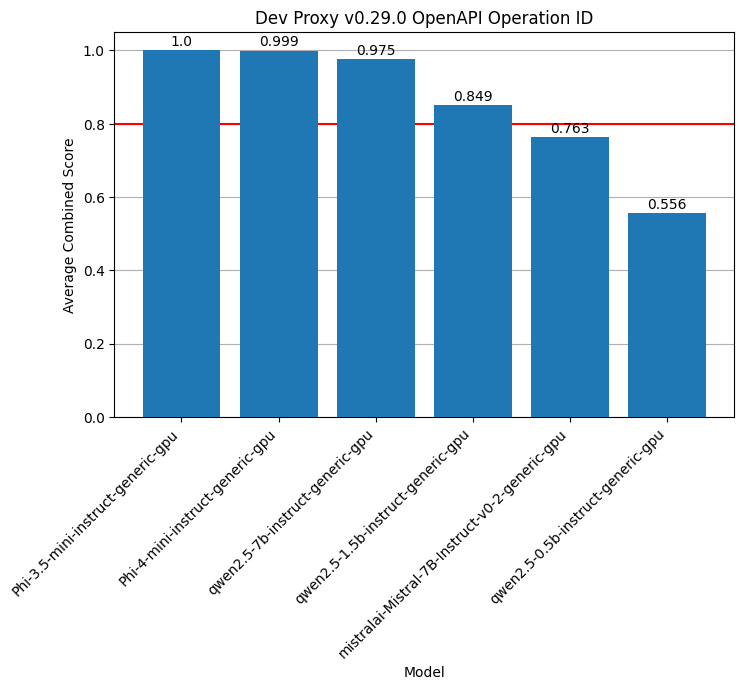

In [13]:
# Chart for average score per model

plt.figure(figsize=(8, 5))
plt.grid(True, axis='y', zorder=0)

bars = plt.bar(df_score_model['model'], df_score_model['average_combined_score'], zorder=3)

# Add values above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 3), ha='center', va='bottom')

# Add horizontal red line at the score threshold to indicate good and bad scores
plt.axhline(y=score_threshold, color='red')

plt.ylim(0, 1.05)
plt.xlabel('Model')
plt.ylabel('Average Combined Score')
plt.title(scenario)
plt.xticks(rotation=45, ha='right')
plt.show()